In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import hist, processor
import numpy as np
import awkward as ak
import matplotlib.pyplot as plt

In [2]:
filename = "/pnfs/psi.ch/cms/trivcat/store/user/mmarcheg/RunIIFall17NanoAODv7/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/587E2464-42CA-3A45-BD49-D23E49F658E6.root"
#events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema).events()
events = NanoEventsFactory.from_root(filename, schemaclass=NanoAODSchema, entry_stop=100).events()

In [3]:
ievt = 1

In [4]:
def parton_matching():
    # Select b-quarks at LHE level
    isOutgoing = events.LHEPart.status == 1
    isB = abs(events.LHEPart.pdgId) == 5
    bquarks = events.LHEPart[isB & isOutgoing]

    # Select b-quarks at Gen level, coming from H->bb decay
    if dataset == 'ttHTobb':
        isHiggs = events.GenPart.pdgId == 25
        isHard = events.GenPart.hasFlags(['fromHardProcess'])
        hasTwoChildren = ak.num(events.GenPart.childrenIdxG, axis=2) == 2
        higgs = events.GenPart[isHiggs & isHard & hasTwoChildren]
        bquarks = ak.concatenate( (bquarks, ak.flatten(higgs.children, axis=2)), axis=1 )
        # Sort b-quarks by pt
        bquarks = ak.with_name(bquarks[ak.argsort(bquarks.pt)], name='PtEtaPhiMCandidate')

    # Compute deltaR(b, jet) and save the nearest jet (deltaR matching)
    deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
    idx_pairs_sorted = ak.argsort(deltaR, axis=1)
    pairs = ak.argcartesian([bquarks, events.Jet])
    pairs_sorted = pairs[idx_pairs_sorted]
    idx_bquarks, idx_Jet = ak.unzip(pairs_sorted)

    print(pairs_sorted[ievt].tolist(), end='\n\n')

    hasMatch = ak.zeros_like(idx_Jet, dtype=bool)
    Npairmax = ak.max(ak.num(idx_bquarks))
    # Loop over the (parton, jet) pairs
    for idx_pair in range(Npairmax):
        idx_bquark = ak.pad_none(idx_bquarks, Npairmax)[:,idx_pair]
        idx_match_candidates = idx_Jet[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        idx_pair_candidates  = ak.local_index(idx_Jet)[ak.fill_none( (idx_bquarks == idx_bquark) & ~hasMatch, False)]
        print(idx_bquark[ievt], idx_match_candidates[ievt])
        print(idx_bquark[ievt], idx_pair_candidates[ievt])
        if idx_pair == 0:
            idx_matchedJet    = ak.unflatten( ak.firsts(idx_match_candidates), 1 )
            idx_matchedParton = ak.unflatten( idx_bquark, 1 )
            idx_matchedPair   = ak.unflatten( ak.firsts(idx_pair_candidates), 1 )
        else:
            # If the partons are matched in all events or the number of jets is smaller than the number of partons, stop iterating
            if ak.all( ( (ak.count(idx_matchedJet, axis=1) == ak.count(bquarks.pt, axis=1)) | (ak.count(events.Jet.pt, axis=1) < ak.count(bquarks.pt, axis=1) ) ) ): break
            idx_matchedJet    = ak.concatenate( (idx_matchedJet, ak.unflatten( ak.firsts(idx_match_candidates), 1 ) ), axis=1 )
            idx_matchedParton = ak.concatenate( (idx_matchedParton, ak.unflatten( idx_bquark, 1 )), axis=1 )
            idx_matchedPair   = ak.concatenate( (idx_matchedPair, ak.unflatten( ak.firsts(idx_pair_candidates), 1 ) ), axis=1 )
        # The mask `hasMatch` masks to False the 
        hasMatch = hasMatch | ak.fill_none(idx_Jet == ak.fill_none(ak.firsts(idx_match_candidates), -99), False) | ak.fill_none(idx_bquarks == idx_bquark, False)
        print(idx_pair, hasMatch[ievt].tolist(), end='\n\n')

    idx_matchedParton = idx_matchedParton[~ak.is_none(idx_matchedJet, axis=1)]
    idx_matchedJet = idx_matchedJet[~ak.is_none(idx_matchedJet, axis=1)]
    dr_matchedJet = deltaR[idx_pairs_sorted][~ak.is_none(idx_matchedPair, axis=1)]
    print("idx_matchedPair", idx_matchedPair)
    idx_matchedPair = idx_matchedPair[~ak.is_none(idx_matchedPair, axis=1)]
    matchedJet    = events.Jet[idx_matchedJet]
    matchedParton = bquarks[idx_matchedParton]
    print("matchedJet", matchedJet)
    hasMatchedPartons = ak.count(idx_matchedParton, axis=1) == ak.count(bquarks.pt, axis=1)
    print(hasMatchedPartons)
    #for cut in self._selections.keys():
    #    print(events.metadata["dataset"], cut, "matched partons =", round(100*ak.sum(hasMatchedPartons[self._cuts.all(*self._selections[cut])])/ak.size(hasMatchedPartons[self._cuts.all(*self._selections[cut])]), 2), "%")
    events["BQuark"] = bquarks
    events["JetMatched"] = matchedJet
    events["BQuarkMatched"] = matchedParton
    events["BQuarkMatched"] = ak.with_field(events.BQuarkMatched, dr_matchedJet, "drMatchedJet")
    print("deltaR", deltaR)
    return bquarks, idx_matchedJet, idx_matchedParton, idx_matchedPair, dr_matchedJet

In [5]:
dataset = "ttHTobb"
bquarks, idx_matchedJet, idx_matchedParton, idx_matchedPair, dr_matchedJet = parton_matching()

[(3, 0), (1, 5), (2, 1), (3, 7), (0, 7), (2, 5), (1, 1), (2, 2), (0, 0), (2, 3), (3, 3), (0, 3), (0, 4), (1, 3), (2, 0), (3, 5), (1, 0), (1, 2), (0, 2), (3, 1), (2, 7), (3, 2), (0, 8), (1, 7), (0, 1), (3, 4), (0, 5), (3, 8), (2, 8), (2, 4), (0, 6), (1, 8), (1, 4), (2, 6), (3, 6), (1, 6)]

3 [0, 7, 3, 5, 1, 2, 4, 8, 6]
3 [0, 3, 10, 15, 19, 21, 25, 27, 34]
0 [True, False, False, True, False, False, False, False, True, False, True, False, False, False, True, True, True, False, False, True, False, True, False, False, False, True, False, True, False, False, False, False, False, False, True, False]

1 [5, 1, 3, 2, 7, 8, 4, 6]
1 [1, 6, 13, 17, 23, 31, 32, 35]
1 [True, True, False, True, False, True, True, False, True, False, True, False, False, True, True, True, True, True, False, True, False, True, False, True, False, True, True, True, False, False, False, True, True, False, True, True]

2 [1, 2, 3, 7, 8, 4, 6]
2 [2, 7, 9, 20, 28, 29, 33]
2 [True, True, True, True, False, True, True, True, T

In [6]:
deltaR = ak.flatten(bquarks.metric_table(events.Jet), axis=2)
idx_pairs_sorted = ak.argsort(deltaR, axis=1)
pairs = ak.argcartesian([bquarks, events.Jet])
pairs_sorted = pairs[idx_pairs_sorted]

In [7]:
print(deltaR[ievt].tolist())
print(pairs_sorted[ievt].tolist())

[1.6532708406448364, 3.295625925064087, 2.91536545753479, 2.0690457820892334, 2.5431392192840576, 4.349359035491943, 5.780805587768555, 1.165016770362854, 3.1722655296325684, 2.900911569595337, 1.5443878173828125, 2.912795066833496, 2.659679412841797, 6.519222259521484, 0.06480082869529724, 8.262446403503418, 3.281663179397583, 5.993892192840576, 2.818077564239502, 0.24081091582775116, 1.573973536491394, 1.7338595390319824, 5.17755651473999, 1.4222795963287354, 6.949051856994629, 3.0221166610717773, 4.846456527709961, 0.057874202728271484, 3.0177724361419678, 3.119097948074341, 1.7795755863189697, 4.232578754425049, 2.8521833419799805, 7.220786094665527, 0.5494140386581421, 4.435528755187988]
[(3, 0), (1, 5), (2, 1), (3, 7), (0, 7), (2, 5), (1, 1), (2, 2), (0, 0), (2, 3), (3, 3), (0, 3), (0, 4), (1, 3), (2, 0), (3, 5), (1, 0), (1, 2), (0, 2), (3, 1), (2, 7), (3, 2), (0, 8), (1, 7), (0, 1), (3, 4), (0, 5), (3, 8), (2, 8), (2, 4), (0, 6), (1, 8), (1, 4), (2, 6), (3, 6), (1, 6)]


In [8]:
deltaR[idx_pairs_sorted][ievt].tolist()

[0.057874202728271484,
 0.06480082869529724,
 0.24081091582775116,
 0.5494140386581421,
 1.165016770362854,
 1.4222795963287354,
 1.5443878173828125,
 1.573973536491394,
 1.6532708406448364,
 1.7338595390319824,
 1.7795755863189697,
 2.0690457820892334,
 2.5431392192840576,
 2.659679412841797,
 2.818077564239502,
 2.8521833419799805,
 2.900911569595337,
 2.912795066833496,
 2.91536545753479,
 3.0177724361419678,
 3.0221166610717773,
 3.119097948074341,
 3.1722655296325684,
 3.281663179397583,
 3.295625925064087,
 4.232578754425049,
 4.349359035491943,
 4.435528755187988,
 4.846456527709961,
 5.17755651473999,
 5.780805587768555,
 5.993892192840576,
 6.519222259521484,
 6.949051856994629,
 7.220786094665527,
 8.262446403503418]

In [9]:
for ievt in range(10):
    print(pairs_sorted[ievt].tolist())
    print(idx_matchedParton[ievt])
    print(idx_matchedJet[ievt], end='\n\n')

[(2, 2), (1, 4), (0, 5), (3, 1), (3, 3), (1, 2), (2, 4), (0, 8), (0, 6), (3, 8), (0, 7), (0, 1), (2, 9), (3, 2), (2, 1), (1, 1), (2, 3), (1, 9), (3, 4), (3, 5), (0, 0), (1, 3), (0, 3), (1, 8), (2, 8), (3, 6), (0, 4), (1, 5), (2, 0), (3, 7), (0, 2), (2, 7), (2, 5), (1, 6), (3, 9), (2, 6), (0, 9), (3, 0), (1, 0), (1, 7)]
[2, 1, 0, 3]
[2, 4, 5, 1]

[(3, 0), (1, 5), (2, 1), (3, 7), (0, 7), (2, 5), (1, 1), (2, 2), (0, 0), (2, 3), (3, 3), (0, 3), (0, 4), (1, 3), (2, 0), (3, 5), (1, 0), (1, 2), (0, 2), (3, 1), (2, 7), (3, 2), (0, 8), (1, 7), (0, 1), (3, 4), (0, 5), (3, 8), (2, 8), (2, 4), (0, 6), (1, 8), (1, 4), (2, 6), (3, 6), (1, 6)]
[3, 1, 2, 0]
[0, 5, 1, 7]

[(2, 2), (3, 0), (0, 8), (1, 5), (0, 4), (2, 8), (3, 7), (1, 4), (0, 2), (2, 3), (3, 8), (3, 5), (0, 0), (0, 5), (1, 1), (1, 0), (3, 2), (2, 0), (3, 9), (1, 8), (1, 7), (2, 6), (3, 4), (2, 1), (0, 3), (2, 4), (1, 3), (3, 1), (2, 5), (1, 9), (0, 7), (2, 7), (1, 2), (3, 3), (3, 6), (0, 1), (0, 6), (0, 9), (2, 9), (1, 6)]
[2, 3, 0, 1]
[2

In [10]:
ievt=1
print(idx_matchedParton[ievt])
print(idx_matchedJet[ievt], end='\n\n')

[3, 1, 2, 0]
[0, 5, 1, 7]



In [11]:
pairs_sorted[ievt].tolist()

[(3, 0),
 (1, 5),
 (2, 1),
 (3, 7),
 (0, 7),
 (2, 5),
 (1, 1),
 (2, 2),
 (0, 0),
 (2, 3),
 (3, 3),
 (0, 3),
 (0, 4),
 (1, 3),
 (2, 0),
 (3, 5),
 (1, 0),
 (1, 2),
 (0, 2),
 (3, 1),
 (2, 7),
 (3, 2),
 (0, 8),
 (1, 7),
 (0, 1),
 (3, 4),
 (0, 5),
 (3, 8),
 (2, 8),
 (2, 4),
 (0, 6),
 (1, 8),
 (1, 4),
 (2, 6),
 (3, 6),
 (1, 6)]

In [12]:
deltaR[idx_pairs_sorted][idx_matchedPair][ievt].tolist()

[0.057874202728271484,
 0.06480082869529724,
 0.24081091582775116,
 1.165016770362854]

In [13]:
deltaR[idx_pairs_sorted][ievt].tolist()

[0.057874202728271484,
 0.06480082869529724,
 0.24081091582775116,
 0.5494140386581421,
 1.165016770362854,
 1.4222795963287354,
 1.5443878173828125,
 1.573973536491394,
 1.6532708406448364,
 1.7338595390319824,
 1.7795755863189697,
 2.0690457820892334,
 2.5431392192840576,
 2.659679412841797,
 2.818077564239502,
 2.8521833419799805,
 2.900911569595337,
 2.912795066833496,
 2.91536545753479,
 3.0177724361419678,
 3.0221166610717773,
 3.119097948074341,
 3.1722655296325684,
 3.281663179397583,
 3.295625925064087,
 4.232578754425049,
 4.349359035491943,
 4.435528755187988,
 4.846456527709961,
 5.17755651473999,
 5.780805587768555,
 5.993892192840576,
 6.519222259521484,
 6.949051856994629,
 7.220786094665527,
 8.262446403503418]

In [14]:
ak.local_index(pairs)

<Array [[0, 1, 2, 3, 4, ... 40, 41, 42, 43]] type='100 * var * int64'>

In [19]:
events.BQuark.pt[1]

<Array [16.9, 39.3, 66.4, 246] type='4 * ?float32'>

In [20]:
events.BQuarkMatched.pt[1]

<Array [246, 39.3, 66.4, 16.9] type='4 * ?float32'>

In [22]:
events.BQuarkMatched.drMatchedJet[1]

<Array [0.0579, 0.0648, 0.241, 1.17] type='4 * ?float32'>

In [24]:
events.BQuarkMatched.eta[1]

<Array [1.58, 3.2, 1.9, -0.0397] type='4 * ?float32'>

In [23]:
events.JetMatched.eta[1]

<Array [1.52, 3.24, 1.79, 1.04] type='4 * ?float32[parameters={"__doc__": "eta"}]'>

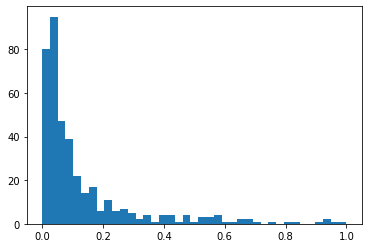

In [29]:
plt.hist(ak.flatten(events.BQuarkMatched.drMatchedJet), bins=np.linspace(0,1,40));